In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["NVIDIA_VISIBLE_DEVICES"] = "1"

In [2]:
import matplotlib.pyplot as plt
from dataclasses import dataclass
from datasets import load_dataset
from torchvision import transforms
import torch
import torch.nn.functional as F
from PIL import Image
from diffusers import DDPMScheduler, UNet2DModel, DDPMPipeline
from accelerate import Accelerator, notebook_launcher
from huggingface_hub import HfFolder, Repository, whoami
from tqdm.auto import tqdm
from pathlib import Path
import math
import os
import glob

In [3]:
print('CUDA availability: {}'.format(torch.cuda.is_available()))
print('Num cores: {}'.format(torch.cuda.device_count()))
print('Current Device: {}'.format(torch.cuda.current_device()))

CUDA availability: True
Num cores: 1
Current Device: 0


# Set Configs

In [4]:
@dataclass
class TrainingConfig:
    # image_size = 128  # the generated image resolution
    image_size = 128
    image_format='RGBA'
    channels=4
    train_batch_size = 16
    eval_batch_size = 16  # how many images to sample during evaluation
    num_epochs = 1000
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 25
    mixed_precision = 'fp16'  # `no` for float32, `fp16` for automatic mixed precision
    # mixed_precision = 'no'  # requires a GPU
    output_dir = 'model_230327'  # the model namy locally and on the HF Hub

    push_to_hub = False  # whether to upload the saved model to the HF Hub
    hub_private_repo = False  
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0

config = TrainingConfig()

# Create the Dataset

In [5]:
DIR="images_4_128/"
dataset = load_dataset("imagefolder", data_dir=DIR)

Resolving data files:   0%|          | 0/1806 [00:00<?, ?it/s]

Found cached dataset imagefolder (/mas/u/doorleyr/.cache/huggingface/datasets/imagefolder/default-55603d574ba543dd/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


  0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
type(dataset['train'][0]['image'])

PIL.PngImagePlugin.PngImageFile

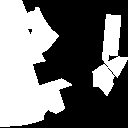

In [7]:
dataset['train'][0]['image'].getchannel(0)

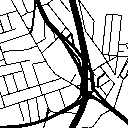

In [8]:
dataset['train'][0]['image'].getchannel(3)

In [9]:
dataset['train'][0]['image'].size

(128, 128)

# Plot a few example images

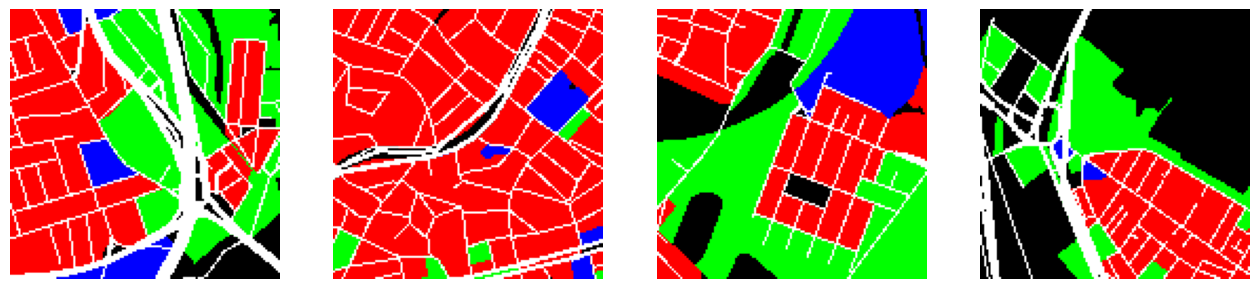

In [10]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset['train'][:4]["image"]):
    axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()

# Apply Transforms

In [11]:
preprocess = transforms.Compose(
    [
        # transforms.Resize((config.image_size, config.image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

In [12]:
def transform(examples):
    images = [preprocess(image.convert(config.image_format)) for image in examples["image"]]
    return {"images": images}

dataset["train"].set_transform(transform)

In [13]:
dataset["train"][0]['images'].shape

torch.Size([4, 128, 128])

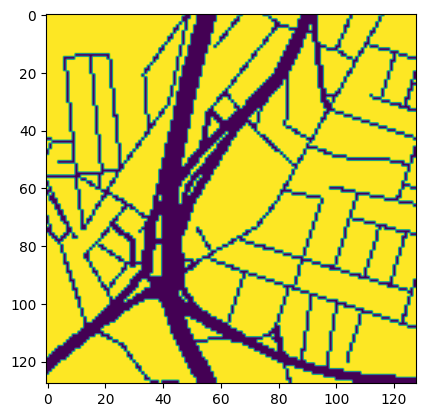

In [14]:
plt.imshow(dataset["train"][0]['images'][3, :, :])

In [15]:
# type(dataset["train"][0]['images'])

# Plot transformed images

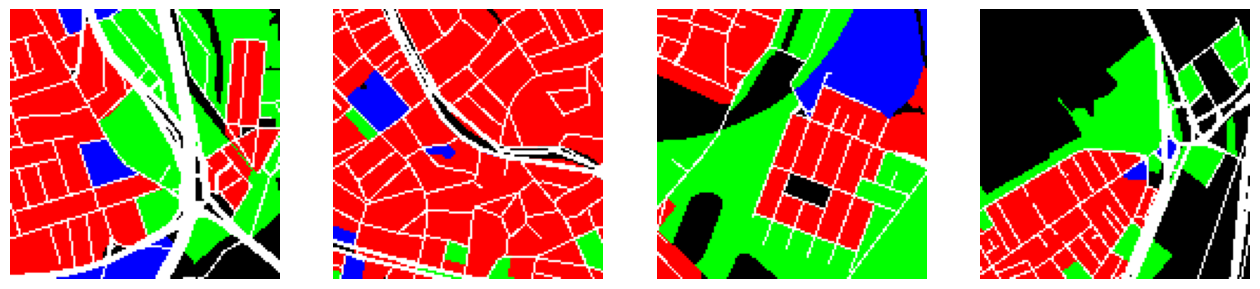

In [16]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset["train"][:4]["images"]):
    axs[i].imshow(image.permute(1, 2, 0).numpy() / 2 + 0.5)
    axs[i].set_axis_off()
fig.show()

# Set up Dataloader

In [17]:
train_dataloader = torch.utils.data.DataLoader(
    dataset["train"], batch_size=config.train_batch_size, shuffle=True)

# Diffusion Model

In [18]:
model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=config.channels,  # the number of input channels, 3 for RGB images
    out_channels=config.channels,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 
                         # 128, 
                        256, 
                        256, 
                        512,
                        512),  # the number of output channes for each UNet block
    down_block_types=( 
        "DownBlock2D",  # a regular ResNet downsampling block
         # "DownBlock2D", 
         "DownBlock2D", 
        "DownBlock2D", 
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ), 
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D", 
         "UpBlock2D", 
         # "UpBlock2D", 
        "UpBlock2D"  
      ),
)

In [19]:
sample_image = dataset["train"][0]['images'].unsqueeze(0)

In [20]:
print('Input shape:', sample_image.shape)

Input shape: torch.Size([1, 4, 128, 128])


In [21]:
print('Output shape:', model(sample_image, timestep=0).sample.shape)

Output shape: torch.Size([1, 4, 128, 128])


## Define the noise scheduler

In [22]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

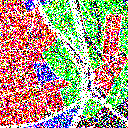

In [23]:
noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([0])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])

In [24]:
noise_pred = model(noisy_image, timesteps).sample
loss = F.mse_loss(noise_pred, noise)
print(loss)

tensor(1.0957, grad_fn=<MseLossBackward0>)


## Set up training

In [25]:
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)

 And a cosine learning rate schedule:

In [26]:
from diffusers.optimization import get_cosine_schedule_with_warmup

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

# Model evaluation with DDPMPipeline

In [27]:
def make_grid(images, rows, cols):
    w, h = images[0].size
    grid = Image.new(config.image_format, size=(cols*w, rows*h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i%cols*w, i//cols*h))
    return grid

def evaluate(config, epoch, pipeline):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        batch_size = config.eval_batch_size, 
        generator=torch.manual_seed(config.seed),
    ).images

    # Make a grid out of the images
    image_grid = make_grid(images, rows=4, cols=4)

    # Save the images
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

# Training Loop

In [28]:
def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps, 
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs")
    )
    if accelerator.is_main_process:
        if config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        accelerator.init_trackers("train_example")

    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )
    
    global_step = 0

    # Now you train the model
    for epoch in range(config.num_epochs):
        print(epoch)
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch['images']
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape).to(clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device).long()

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)
            
            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()
            
            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            print(logs)
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline)

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                pipeline.save_pretrained(config.output_dir) 

# Train Model

In [30]:
%load_ext tensorboard

In [ ]:
args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

notebook_launcher(train_loop, args, num_processes=1)

Launching training on one GPU.


/mas/u/doorleyr/.pyenv/versions/torch_lu/lib/python3.9/site-packages/accelerate/accelerator.py:359: UserWarning: `log_with=tensorboard` was passed but no supported trackers are currently installed.
  warnings.warn(f"`log_with={log_with}` was passed but no supported trackers are currently installed.")


0


  0%|          | 0/113 [00:00<?, ?it/s]

{'loss': 1.1520137786865234, 'lr': 2.0000000000000002e-07, 'step': 0}
{'loss': 1.1485110521316528, 'lr': 4.0000000000000003e-07, 'step': 1}
{'loss': 1.151102066040039, 'lr': 6.000000000000001e-07, 'step': 2}
{'loss': 1.1534578800201416, 'lr': 8.000000000000001e-07, 'step': 3}
{'loss': 1.151645302772522, 'lr': 1.0000000000000002e-06, 'step': 4}
{'loss': 1.1476606130599976, 'lr': 1.2000000000000002e-06, 'step': 5}
{'loss': 1.1377573013305664, 'lr': 1.4000000000000001e-06, 'step': 6}
{'loss': 1.1438087224960327, 'lr': 1.6000000000000001e-06, 'step': 7}
{'loss': 1.1420252323150635, 'lr': 1.8e-06, 'step': 8}
{'loss': 1.1330126523971558, 'lr': 2.0000000000000003e-06, 'step': 9}
{'loss': 1.1254490613937378, 'lr': 2.2e-06, 'step': 10}
{'loss': 1.1157336235046387, 'lr': 2.4000000000000003e-06, 'step': 11}
{'loss': 1.1169195175170898, 'lr': 2.6e-06, 'step': 12}
{'loss': 1.106734037399292, 'lr': 2.8000000000000003e-06, 'step': 13}
{'loss': 1.095825433731079, 'lr': 3e-06, 'step': 14}
{'loss': 1.08

  0%|          | 0/113 [00:00<?, ?it/s]

{'loss': 0.21204189956188202, 'lr': 2.2800000000000002e-05, 'step': 113}
{'loss': 0.12369184195995331, 'lr': 2.3000000000000003e-05, 'step': 114}
{'loss': 0.1590544730424881, 'lr': 2.32e-05, 'step': 115}
{'loss': 0.1901790201663971, 'lr': 2.3400000000000003e-05, 'step': 116}
{'loss': 0.15638881921768188, 'lr': 2.36e-05, 'step': 117}
{'loss': 0.18098166584968567, 'lr': 2.38e-05, 'step': 118}
{'loss': 0.09764859080314636, 'lr': 2.4e-05, 'step': 119}
{'loss': 0.19561584293842316, 'lr': 2.4200000000000002e-05, 'step': 120}
{'loss': 0.08527608215808868, 'lr': 2.44e-05, 'step': 121}
{'loss': 0.08482487499713898, 'lr': 2.46e-05, 'step': 122}
{'loss': 0.09309310466051102, 'lr': 2.48e-05, 'step': 123}
{'loss': 0.15579012036323547, 'lr': 2.5e-05, 'step': 124}
{'loss': 0.110441654920578, 'lr': 2.5200000000000003e-05, 'step': 125}
{'loss': 0.12347692996263504, 'lr': 2.54e-05, 'step': 126}
{'loss': 0.2072840929031372, 'lr': 2.5600000000000002e-05, 'step': 127}
{'loss': 0.18694129586219788, 'lr': 2.

  0%|          | 0/113 [00:00<?, ?it/s]

{'loss': 0.06838538497686386, 'lr': 4.5400000000000006e-05, 'step': 226}
{'loss': 0.07323974370956421, 'lr': 4.5600000000000004e-05, 'step': 227}
{'loss': 0.1119517907500267, 'lr': 4.58e-05, 'step': 228}
{'loss': 0.07074760645627975, 'lr': 4.600000000000001e-05, 'step': 229}
{'loss': 0.07128403335809708, 'lr': 4.6200000000000005e-05, 'step': 230}
{'loss': 0.13885602355003357, 'lr': 4.64e-05, 'step': 231}
{'loss': 0.14233005046844482, 'lr': 4.660000000000001e-05, 'step': 232}
{'loss': 0.11347303539514542, 'lr': 4.6800000000000006e-05, 'step': 233}
{'loss': 0.07695254683494568, 'lr': 4.7e-05, 'step': 234}
{'loss': 0.05600956082344055, 'lr': 4.72e-05, 'step': 235}
{'loss': 0.05146840587258339, 'lr': 4.74e-05, 'step': 236}
{'loss': 0.05548655986785889, 'lr': 4.76e-05, 'step': 237}
{'loss': 0.0750504732131958, 'lr': 4.78e-05, 'step': 238}
{'loss': 0.08129006624221802, 'lr': 4.8e-05, 'step': 239}
{'loss': 0.09462258964776993, 'lr': 4.82e-05, 'step': 240}
{'loss': 0.10487788915634155, 'lr': 4

  0%|          | 0/113 [00:00<?, ?it/s]

{'loss': 0.05313113331794739, 'lr': 6.800000000000001e-05, 'step': 339}
{'loss': 0.05570283532142639, 'lr': 6.82e-05, 'step': 340}
{'loss': 0.07032911479473114, 'lr': 6.840000000000001e-05, 'step': 341}
{'loss': 0.0762491300702095, 'lr': 6.860000000000001e-05, 'step': 342}
{'loss': 0.1253049075603485, 'lr': 6.879999999999999e-05, 'step': 343}
{'loss': 0.08073125779628754, 'lr': 6.9e-05, 'step': 344}
{'loss': 0.07869109511375427, 'lr': 6.92e-05, 'step': 345}
{'loss': 0.030246026813983917, 'lr': 6.939999999999999e-05, 'step': 346}
{'loss': 0.04077621549367905, 'lr': 6.96e-05, 'step': 347}
{'loss': 0.057124074548482895, 'lr': 6.98e-05, 'step': 348}
{'loss': 0.06766384840011597, 'lr': 7e-05, 'step': 349}
{'loss': 0.04476459324359894, 'lr': 7.02e-05, 'step': 350}
{'loss': 0.12182141095399857, 'lr': 7.04e-05, 'step': 351}
{'loss': 0.06841421872377396, 'lr': 7.06e-05, 'step': 352}
{'loss': 0.06409959495067596, 'lr': 7.08e-05, 'step': 353}
{'loss': 0.0930991917848587, 'lr': 7.1e-05, 'step': 35

  0%|          | 0/113 [00:00<?, ?it/s]

{'loss': 0.04415031149983406, 'lr': 9.06e-05, 'step': 452}
{'loss': 0.103009894490242, 'lr': 9.080000000000001e-05, 'step': 453}
{'loss': 0.0882108062505722, 'lr': 9.1e-05, 'step': 454}
{'loss': 0.035885557532310486, 'lr': 9.120000000000001e-05, 'step': 455}
{'loss': 0.04693715274333954, 'lr': 9.140000000000001e-05, 'step': 456}
{'loss': 0.0397813618183136, 'lr': 9.16e-05, 'step': 457}
{'loss': 0.045706652104854584, 'lr': 9.180000000000001e-05, 'step': 458}
{'loss': 0.03720356523990631, 'lr': 9.200000000000001e-05, 'step': 459}
{'loss': 0.07942559570074081, 'lr': 9.22e-05, 'step': 460}
{'loss': 0.07528027147054672, 'lr': 9.240000000000001e-05, 'step': 461}
{'loss': 0.04994317889213562, 'lr': 9.260000000000001e-05, 'step': 462}
{'loss': 0.04224472865462303, 'lr': 9.28e-05, 'step': 463}
{'loss': 0.03664300590753555, 'lr': 9.300000000000001e-05, 'step': 464}
{'loss': 0.09018812328577042, 'lr': 9.320000000000002e-05, 'step': 465}
{'loss': 0.048539746552705765, 'lr': 9.340000000000001e-05, 

  0%|          | 0/113 [00:00<?, ?it/s]

{'loss': 0.03255070745944977, 'lr': 9.999991507756128e-05, 'step': 565}
{'loss': 0.03137710690498352, 'lr': 9.99999124846593e-05, 'step': 566}
{'loss': 0.03154772147536278, 'lr': 9.999990985276635e-05, 'step': 567}
{'loss': 0.05074359104037285, 'lr': 9.999990718188245e-05, 'step': 568}
{'loss': 0.07798837870359421, 'lr': 9.999990447200757e-05, 'step': 569}
{'loss': 0.04571700096130371, 'lr': 9.999990172314176e-05, 'step': 570}
{'loss': 0.0627652257680893, 'lr': 9.999989893528499e-05, 'step': 571}
{'loss': 0.050994694232940674, 'lr': 9.999989610843725e-05, 'step': 572}
{'loss': 0.051974281668663025, 'lr': 9.999989324259858e-05, 'step': 573}
{'loss': 0.06122000887989998, 'lr': 9.999989033776898e-05, 'step': 574}
{'loss': 0.044464461505413055, 'lr': 9.99998873939484e-05, 'step': 575}
{'loss': 0.08142270892858505, 'lr': 9.99998844111369e-05, 'step': 576}
{'loss': 0.0513494610786438, 'lr': 9.999988138933444e-05, 'step': 577}
{'loss': 0.04893249273300171, 'lr': 9.999987832854107e-05, 'step':

  0%|          | 0/113 [00:00<?, ?it/s]

{'loss': 0.034939080476760864, 'lr': 9.999937534550883e-05, 'step': 678}
{'loss': 0.02520824782550335, 'lr': 9.99993683466483e-05, 'step': 679}
{'loss': 0.05268745869398117, 'lr': 9.999936130879723e-05, 'step': 680}
{'loss': 0.03882637247443199, 'lr': 9.999935423195563e-05, 'step': 681}
{'loss': 0.03413979709148407, 'lr': 9.999934711612351e-05, 'step': 682}
{'loss': 0.06044795364141464, 'lr': 9.999933996130087e-05, 'step': 683}
{'loss': 0.04633105546236038, 'lr': 9.999933276748771e-05, 'step': 684}
{'loss': 0.040560536086559296, 'lr': 9.999932553468404e-05, 'step': 685}
{'loss': 0.04846882447600365, 'lr': 9.999931826288987e-05, 'step': 686}
{'loss': 0.03836003318428993, 'lr': 9.99993109521052e-05, 'step': 687}
{'loss': 0.03663408011198044, 'lr': 9.999930360233003e-05, 'step': 688}
{'loss': 0.03334428369998932, 'lr': 9.999929621356438e-05, 'step': 689}
{'loss': 0.10024656355381012, 'lr': 9.999928878580827e-05, 'step': 690}
{'loss': 0.03190135210752487, 'lr': 9.999928131906165e-05, 'step

  0%|          | 0/113 [00:00<?, ?it/s]

{'loss': 0.06732365489006042, 'lr': 9.999833774363085e-05, 'step': 791}
{'loss': 0.02700762450695038, 'lr': 9.999832633888147e-05, 'step': 792}
{'loss': 0.024044755846261978, 'lr': 9.999831489514236e-05, 'step': 793}
{'loss': 0.05471755191683769, 'lr': 9.999830341241353e-05, 'step': 794}
{'loss': 0.030365217477083206, 'lr': 9.999829189069503e-05, 'step': 795}
{'loss': 0.044412001967430115, 'lr': 9.999828032998679e-05, 'step': 796}
{'loss': 0.02721792832016945, 'lr': 9.999826873028889e-05, 'step': 797}
{'loss': 0.03816242888569832, 'lr': 9.99982570916013e-05, 'step': 798}
{'loss': 0.038442108780145645, 'lr': 9.999824541392405e-05, 'step': 799}
{'loss': 0.029847120866179466, 'lr': 9.999823369725712e-05, 'step': 800}
{'loss': 0.028994791209697723, 'lr': 9.999822194160053e-05, 'step': 801}
{'loss': 0.040654368698596954, 'lr': 9.999821014695432e-05, 'step': 802}
{'loss': 0.023892290890216827, 'lr': 9.999819831331847e-05, 'step': 803}
{'loss': 0.024969730526208878, 'lr': 9.999818644069299e-0

  0%|          | 0/113 [00:00<?, ?it/s]

{'loss': 0.035317689180374146, 'lr': 9.99968022822593e-05, 'step': 904}
{'loss': 0.06685672700405121, 'lr': 9.999678647173463e-05, 'step': 905}
{'loss': 0.043384965509176254, 'lr': 9.999677062222144e-05, 'step': 906}
{'loss': 0.017995605245232582, 'lr': 9.999675473371974e-05, 'step': 907}
{'loss': 0.06750346720218658, 'lr': 9.999673880622956e-05, 'step': 908}
{'loss': 0.08806535601615906, 'lr': 9.999672283975086e-05, 'step': 909}
{'loss': 0.03985697031021118, 'lr': 9.99967068342837e-05, 'step': 910}
{'loss': 0.03675957769155502, 'lr': 9.999669078982809e-05, 'step': 911}
{'loss': 0.019068147987127304, 'lr': 9.999667470638401e-05, 'step': 912}
{'loss': 0.031191015616059303, 'lr': 9.99966585839515e-05, 'step': 913}
{'loss': 0.03152567893266678, 'lr': 9.999664242253057e-05, 'step': 914}
{'loss': 0.034374624490737915, 'lr': 9.999662622212122e-05, 'step': 915}
{'loss': 0.029307710006833076, 'lr': 9.99966099827235e-05, 'step': 916}
{'loss': 0.07951153814792633, 'lr': 9.999659370433736e-05, 's

  0%|          | 0/113 [00:00<?, ?it/s]

{'loss': 0.04225017875432968, 'lr': 9.999476897668356e-05, 'step': 1017}
{'loss': 0.028577201068401337, 'lr': 9.999474876054104e-05, 'step': 1018}
{'loss': 0.033992040902376175, 'lr': 9.99947285054116e-05, 'step': 1019}
{'loss': 0.030349958688020706, 'lr': 9.999470821129522e-05, 'step': 1020}
{'loss': 0.02529033273458481, 'lr': 9.999468787819195e-05, 'step': 1021}
{'loss': 0.022494371980428696, 'lr': 9.999466750610179e-05, 'step': 1022}
{'loss': 0.08918650448322296, 'lr': 9.999464709502476e-05, 'step': 1023}
{'loss': 0.05920133367180824, 'lr': 9.999462664496088e-05, 'step': 1024}
{'loss': 0.024267658591270447, 'lr': 9.999460615591014e-05, 'step': 1025}
{'loss': 0.04817183315753937, 'lr': 9.999458562787259e-05, 'step': 1026}
{'loss': 0.04529585316777229, 'lr': 9.999456506084823e-05, 'step': 1027}
{'loss': 0.0212397500872612, 'lr': 9.99945444548371e-05, 'step': 1028}
{'loss': 0.07983919978141785, 'lr': 9.999452380983916e-05, 'step': 1029}
{'loss': 0.032655708491802216, 'lr': 9.9994503125

{'loss': 0.025649745017290115, 'lr': 9.999226242972444e-05, 'step': 1129}


  0%|          | 0/1000 [00:00<?, ?it/s]

10


  0%|          | 0/113 [00:00<?, ?it/s]

{'loss': 0.03289856016635895, 'lr': 9.999223784715036e-05, 'step': 1130}
{'loss': 0.030179528519511223, 'lr': 9.999221322559126e-05, 'step': 1131}
{'loss': 0.016343675553798676, 'lr': 9.999218856504724e-05, 'step': 1132}
{'loss': 0.012568988837301731, 'lr': 9.999216386551828e-05, 'step': 1133}
{'loss': 0.0363791324198246, 'lr': 9.99921391270044e-05, 'step': 1134}
{'loss': 0.014160658232867718, 'lr': 9.999211434950561e-05, 'step': 1135}
{'loss': 0.044381871819496155, 'lr': 9.999208953302196e-05, 'step': 1136}
{'loss': 0.02343800663948059, 'lr': 9.999206467755345e-05, 'step': 1137}
{'loss': 0.053602434694767, 'lr': 9.999203978310007e-05, 'step': 1138}
{'loss': 0.025488656014204025, 'lr': 9.999201484966188e-05, 'step': 1139}
{'loss': 0.039551131427288055, 'lr': 9.99919898772389e-05, 'step': 1140}
{'loss': 0.03408211097121239, 'lr': 9.999196486583112e-05, 'step': 1141}
{'loss': 0.03707414120435715, 'lr': 9.999193981543859e-05, 'step': 1142}
{'loss': 0.027206474915146828, 'lr': 9.9991914726

{'loss': 0.03666627034544945, 'lr': 9.998923790661123e-05, 'step': 1242}
11


  0%|          | 0/113 [00:00<?, ?it/s]

{'loss': 0.02692515030503273, 'lr': 9.998920891886339e-05, 'step': 1243}
{'loss': 0.02316998690366745, 'lr': 9.998917989213295e-05, 'step': 1244}
{'loss': 0.04008442908525467, 'lr': 9.998915082641991e-05, 'step': 1245}
{'loss': 0.04521401599049568, 'lr': 9.99891217217243e-05, 'step': 1246}
{'loss': 0.04713326692581177, 'lr': 9.998909257804613e-05, 'step': 1247}
{'loss': 0.020769216120243073, 'lr': 9.998906339538547e-05, 'step': 1248}
{'loss': 0.02067691460251808, 'lr': 9.998903417374228e-05, 'step': 1249}
{'loss': 0.030027028173208237, 'lr': 9.998900491311662e-05, 'step': 1250}
{'loss': 0.020066935569047928, 'lr': 9.998897561350851e-05, 'step': 1251}
{'loss': 0.05803748965263367, 'lr': 9.998894627491795e-05, 'step': 1252}
{'loss': 0.027024494484066963, 'lr': 9.9988916897345e-05, 'step': 1253}
{'loss': 0.027602195739746094, 'lr': 9.998888748078966e-05, 'step': 1254}
{'loss': 0.02091648243367672, 'lr': 9.998885802525196e-05, 'step': 1255}
{'loss': 0.03661249577999115, 'lr': 9.99888285307

{'loss': 0.060647450387477875, 'lr': 9.998571561461627e-05, 'step': 1355}
12


  0%|          | 0/113 [00:00<?, ?it/s]

{'loss': 0.029295096173882484, 'lr': 9.998568222198335e-05, 'step': 1356}
{'loss': 0.02132246270775795, 'lr': 9.998564879037055e-05, 'step': 1357}
{'loss': 0.054843515157699585, 'lr': 9.99856153197779e-05, 'step': 1358}
{'loss': 0.020205341279506683, 'lr': 9.998558181020547e-05, 'step': 1359}
{'loss': 0.018501922488212585, 'lr': 9.998554826165323e-05, 'step': 1360}
{'loss': 0.018797466531395912, 'lr': 9.998551467412125e-05, 'step': 1361}
{'loss': 0.04154966399073601, 'lr': 9.998548104760951e-05, 'step': 1362}
{'loss': 0.02403397485613823, 'lr': 9.998544738211809e-05, 'step': 1363}
{'loss': 0.02582399919629097, 'lr': 9.998541367764697e-05, 'step': 1364}
{'loss': 0.03653237223625183, 'lr': 9.99853799341962e-05, 'step': 1365}
{'loss': 0.018284734338521957, 'lr': 9.99853461517658e-05, 'step': 1366}
{'loss': 0.03135489672422409, 'lr': 9.99853123303558e-05, 'step': 1367}
{'loss': 0.027425862848758698, 'lr': 9.998527846996624e-05, 'step': 1368}
{'loss': 0.02699839323759079, 'lr': 9.9985244570

{'loss': 0.019582800567150116, 'lr': 9.998169558881286e-05, 'step': 1468}
13


  0%|          | 0/113 [00:00<?, ?it/s]

{'loss': 0.030601585283875465, 'lr': 9.998165779162734e-05, 'step': 1469}
{'loss': 0.015021372586488724, 'lr': 9.998161995546509e-05, 'step': 1470}
{'loss': 0.022049013525247574, 'lr': 9.998158208032615e-05, 'step': 1471}
{'loss': 0.05152048543095589, 'lr': 9.998154416621054e-05, 'step': 1472}
{'loss': 0.02141440100967884, 'lr': 9.99815062131183e-05, 'step': 1473}
{'loss': 0.022997429594397545, 'lr': 9.998146822104943e-05, 'step': 1474}
{'loss': 0.01602216809988022, 'lr': 9.998143019000401e-05, 'step': 1475}
{'loss': 0.028303271159529686, 'lr': 9.998139211998204e-05, 'step': 1476}
{'loss': 0.021417561918497086, 'lr': 9.998135401098354e-05, 'step': 1477}
{'loss': 0.023797260597348213, 'lr': 9.998131586300854e-05, 'step': 1478}
{'loss': 0.027625713497400284, 'lr': 9.998127767605709e-05, 'step': 1479}
{'loss': 0.025082962587475777, 'lr': 9.998123945012922e-05, 'step': 1480}
{'loss': 0.02089790068566799, 'lr': 9.998120118522494e-05, 'step': 1481}
{'loss': 0.022104740142822266, 'lr': 9.9981

{'loss': 0.023882044479250908, 'lr': 9.997717786923047e-05, 'step': 1581}
14


  0%|          | 0/113 [00:00<?, ?it/s]

{'loss': 0.02069324441254139, 'lr': 9.997713566786874e-05, 'step': 1582}
{'loss': 0.029634974896907806, 'lr': 9.99770934275338e-05, 'step': 1583}
{'loss': 0.0265316404402256, 'lr': 9.997705114822569e-05, 'step': 1584}
{'loss': 0.013605541549623013, 'lr': 9.997700882994445e-05, 'step': 1585}
{'loss': 0.023091210052371025, 'lr': 9.99769664726901e-05, 'step': 1586}
{'loss': 0.024948593229055405, 'lr': 9.997692407646268e-05, 'step': 1587}
{'loss': 0.042714186012744904, 'lr': 9.997688164126224e-05, 'step': 1588}
{'loss': 0.026437796652317047, 'lr': 9.99768391670888e-05, 'step': 1589}
{'loss': 0.017144450917840004, 'lr': 9.997679665394239e-05, 'step': 1590}
{'loss': 0.02822260558605194, 'lr': 9.997675410182304e-05, 'step': 1591}
{'loss': 0.01656017079949379, 'lr': 9.997671151073078e-05, 'step': 1592}
{'loss': 0.029430076479911804, 'lr': 9.997666888066566e-05, 'step': 1593}
{'loss': 0.017212314531207085, 'lr': 9.997662621162771e-05, 'step': 1594}
{'loss': 0.03610556572675705, 'lr': 9.99765835

{'loss': 0.02040543034672737, 'lr': 9.997216250085442e-05, 'step': 1694}
15


  0%|          | 0/113 [00:00<?, ?it/s]

{'loss': 0.037645284086465836, 'lr': 9.997211589573668e-05, 'step': 1695}
{'loss': 0.014342349022626877, 'lr': 9.997206925164965e-05, 'step': 1696}
{'loss': 0.022270016372203827, 'lr': 9.997202256859337e-05, 'step': 1697}
{'loss': 0.022630803287029266, 'lr': 9.997197584656788e-05, 'step': 1698}
{'loss': 0.01617317833006382, 'lr': 9.997192908557323e-05, 'step': 1699}
{'loss': 0.045593660324811935, 'lr': 9.997188228560941e-05, 'step': 1700}
{'loss': 0.013838063925504684, 'lr': 9.997183544667652e-05, 'step': 1701}
{'loss': 0.026978999376296997, 'lr': 9.997178856877454e-05, 'step': 1702}
{'loss': 0.023863961920142174, 'lr': 9.997174165190353e-05, 'step': 1703}
{'loss': 0.03642834722995758, 'lr': 9.997169469606353e-05, 'step': 1704}
{'loss': 0.021257340908050537, 'lr': 9.997164770125458e-05, 'step': 1705}
{'loss': 0.02201361581683159, 'lr': 9.99716006674767e-05, 'step': 1706}
{'loss': 0.017667632550001144, 'lr': 9.997155359472995e-05, 'step': 1707}
{'loss': 0.021484145894646645, 'lr': 9.997

{'loss': 0.01941550523042679, 'lr': 9.996664953362533e-05, 'step': 1807}
16


  0%|          | 0/113 [00:00<?, ?it/s]

{'loss': 0.018168669193983078, 'lr': 9.996659852521565e-05, 'step': 1808}
{'loss': 0.02438080683350563, 'lr': 9.9966547477841e-05, 'step': 1809}
{'loss': 0.020909227430820465, 'lr': 9.99664963915014e-05, 'step': 1810}
{'loss': 0.017267152667045593, 'lr': 9.996644526619689e-05, 'step': 1811}
{'loss': 0.03776992857456207, 'lr': 9.996639410192754e-05, 'step': 1812}
{'loss': 0.014722312800586224, 'lr': 9.996634289869334e-05, 'step': 1813}
{'loss': 0.015620307996869087, 'lr': 9.996629165649438e-05, 'step': 1814}
{'loss': 0.07138454914093018, 'lr': 9.996624037533067e-05, 'step': 1815}
{'loss': 0.03197907656431198, 'lr': 9.996618905520224e-05, 'step': 1816}
{'loss': 0.011811727657914162, 'lr': 9.996613769610917e-05, 'step': 1817}
{'loss': 0.016140446066856384, 'lr': 9.996608629805147e-05, 'step': 1818}
{'loss': 0.011527765542268753, 'lr': 9.996603486102918e-05, 'step': 1819}
{'loss': 0.019481565803289413, 'lr': 9.996598338504235e-05, 'step': 1820}
{'loss': 0.01698351837694645, 'lr': 9.9965931

{'loss': 0.02317488007247448, 'lr': 9.996063902243867e-05, 'step': 1920}
17


  0%|          | 0/113 [00:00<?, ?it/s]

{'loss': 0.03900151699781418, 'lr': 9.996058361124498e-05, 'step': 1921}
{'loss': 0.020023005083203316, 'lr': 9.9960528161091e-05, 'step': 1922}
{'loss': 0.027005953714251518, 'lr': 9.996047267197678e-05, 'step': 1923}
{'loss': 0.018724540248513222, 'lr': 9.996041714390235e-05, 'step': 1924}
{'loss': 0.025824327021837234, 'lr': 9.996036157686774e-05, 'step': 1925}
{'loss': 0.01297962386161089, 'lr': 9.996030597087305e-05, 'step': 1926}
{'loss': 0.018359186127781868, 'lr': 9.996025032591825e-05, 'step': 1927}
{'loss': 0.012198271229863167, 'lr': 9.996019464200344e-05, 'step': 1928}
{'loss': 0.011457759886980057, 'lr': 9.996013891912863e-05, 'step': 1929}
{'loss': 0.012124422937631607, 'lr': 9.996008315729386e-05, 'step': 1930}
{'loss': 0.018990634009242058, 'lr': 9.996002735649921e-05, 'step': 1931}
{'loss': 0.01375444233417511, 'lr': 9.99599715167447e-05, 'step': 1932}
{'loss': 0.01426511537283659, 'lr': 9.995991563803037e-05, 'step': 1933}
{'loss': 0.02313745766878128, 'lr': 9.9959859

{'loss': 0.02074946090579033, 'lr': 9.995413102714425e-05, 'step': 2033}
18


  0%|          | 0/113 [00:00<?, ?it/s]

{'loss': 0.02440568432211876, 'lr': 9.995407121371831e-05, 'step': 2034}
{'loss': 0.020478351041674614, 'lr': 9.995401136133715e-05, 'step': 2035}
{'loss': 0.0653328225016594, 'lr': 9.995395147000083e-05, 'step': 2036}
{'loss': 0.016176339238882065, 'lr': 9.99538915397094e-05, 'step': 2037}
{'loss': 0.037758879363536835, 'lr': 9.995383157046288e-05, 'step': 2038}
{'loss': 0.009691323153674603, 'lr': 9.995377156226133e-05, 'step': 2039}
{'loss': 0.02085074782371521, 'lr': 9.995371151510482e-05, 'step': 2040}
{'loss': 0.015530642122030258, 'lr': 9.995365142899336e-05, 'step': 2041}
{'loss': 0.023389125242829323, 'lr': 9.995359130392703e-05, 'step': 2042}
{'loss': 0.015998780727386475, 'lr': 9.995353113990584e-05, 'step': 2043}
{'loss': 0.026409242302179337, 'lr': 9.995347093692987e-05, 'step': 2044}
{'loss': 0.009280472062528133, 'lr': 9.995341069499915e-05, 'step': 2045}
{'loss': 0.017766593024134636, 'lr': 9.995335041411374e-05, 'step': 2046}
{'loss': 0.0346297025680542, 'lr': 9.995329

{'loss': 0.01721593178808689, 'lr': 9.994712561254555e-05, 'step': 2146}
19


  0%|          | 0/113 [00:00<?, ?it/s]

{'loss': 0.01623287796974182, 'lr': 9.994706139748296e-05, 'step': 2147}
{'loss': 0.013845359906554222, 'lr': 9.994699714347061e-05, 'step': 2148}
{'loss': 0.015585248358547688, 'lr': 9.994693285050857e-05, 'step': 2149}
{'loss': 0.01882307603955269, 'lr': 9.994686851859687e-05, 'step': 2150}
{'loss': 0.04608602821826935, 'lr': 9.994680414773558e-05, 'step': 2151}
{'loss': 0.02455737814307213, 'lr': 9.994673973792475e-05, 'step': 2152}
{'loss': 0.017078403383493423, 'lr': 9.994667528916441e-05, 'step': 2153}
{'loss': 0.018599659204483032, 'lr': 9.994661080145464e-05, 'step': 2154}
{'loss': 0.015115486457943916, 'lr': 9.994654627479547e-05, 'step': 2155}
{'loss': 0.027053646743297577, 'lr': 9.994648170918695e-05, 'step': 2156}
{'loss': 0.020216014236211777, 'lr': 9.994641710462914e-05, 'step': 2157}
{'loss': 0.01743096485733986, 'lr': 9.994635246112208e-05, 'step': 2158}
{'loss': 0.01562567427754402, 'lr': 9.994628777866581e-05, 'step': 2159}
{'loss': 0.01720130443572998, 'lr': 9.994622

{'loss': 0.021350793540477753, 'lr': 9.993962284839918e-05, 'step': 2259}


  0%|          | 0/1000 [00:00<?, ?it/s]

20


  0%|          | 0/113 [00:00<?, ?it/s]

{'loss': 0.01923641934990883, 'lr': 9.993955423233934e-05, 'step': 2260}
{'loss': 0.017168745398521423, 'lr': 9.99394855773356e-05, 'step': 2261}
{'loss': 0.01155050378292799, 'lr': 9.993941688338803e-05, 'step': 2262}
{'loss': 0.00941656157374382, 'lr': 9.993934815049667e-05, 'step': 2263}
{'loss': 0.02084944024682045, 'lr': 9.993927937866158e-05, 'step': 2264}
{'loss': 0.010743798688054085, 'lr': 9.993921056788281e-05, 'step': 2265}
{'loss': 0.04464322701096535, 'lr': 9.993914171816042e-05, 'step': 2266}
{'loss': 0.01631346344947815, 'lr': 9.993907282949446e-05, 'step': 2267}
{'loss': 0.03958006575703621, 'lr': 9.993900390188498e-05, 'step': 2268}
{'loss': 0.018598558381199837, 'lr': 9.993893493533202e-05, 'step': 2269}
{'loss': 0.027135450392961502, 'lr': 9.993886592983568e-05, 'step': 2270}
{'loss': 0.019875861704349518, 'lr': 9.993879688539596e-05, 'step': 2271}
{'loss': 0.023086225613951683, 'lr': 9.993872780201294e-05, 'step': 2272}
{'loss': 0.017027834430336952, 'lr': 9.9938658

{'loss': 0.024437906220555305, 'lr': 9.993162280941402e-05, 'step': 2372}
21


  0%|          | 0/113 [00:00<?, ?it/s]

{'loss': 0.018710890784859657, 'lr': 9.993154979304018e-05, 'step': 2373}
{'loss': 0.015957346186041832, 'lr': 9.99314767377287e-05, 'step': 2374}
{'loss': 0.031224433332681656, 'lr': 9.993140364347962e-05, 'step': 2375}
{'loss': 0.028246620669960976, 'lr': 9.9931330510293e-05, 'step': 2376}
{'loss': 0.030843403190374374, 'lr': 9.993125733816891e-05, 'step': 2377}
{'loss': 0.013509475626051426, 'lr': 9.99311841271074e-05, 'step': 2378}
{'loss': 0.01481771469116211, 'lr': 9.993111087710851e-05, 'step': 2379}
{'loss': 0.018160726875066757, 'lr': 9.993103758817232e-05, 'step': 2380}
{'loss': 0.014448081143200397, 'lr': 9.993096426029889e-05, 'step': 2381}
{'loss': 0.04127690941095352, 'lr': 9.993089089348824e-05, 'step': 2382}
{'loss': 0.016950013116002083, 'lr': 9.993081748774047e-05, 'step': 2383}
{'loss': 0.01599261909723282, 'lr': 9.993074404305563e-05, 'step': 2384}
{'loss': 0.01328042708337307, 'lr': 9.993067055943375e-05, 'step': 2385}
{'loss': 0.02198990434408188, 'lr': 9.99305970

{'loss': 0.05340417101979256, 'lr': 9.992312557525064e-05, 'step': 2485}
22


  0%|          | 0/113 [00:00<?, ?it/s]

{'loss': 0.019956640899181366, 'lr': 9.992304815928988e-05, 'step': 2486}
{'loss': 0.01580662652850151, 'lr': 9.992297070439808e-05, 'step': 2487}
{'loss': 0.039092373102903366, 'lr': 9.992289321057535e-05, 'step': 2488}
{'loss': 0.013287941925227642, 'lr': 9.99228156778217e-05, 'step': 2489}
{'loss': 0.012724803760647774, 'lr': 9.992273810613721e-05, 'step': 2490}
{'loss': 0.014085693284869194, 'lr': 9.992266049552195e-05, 'step': 2491}
{'loss': 0.029668280854821205, 'lr': 9.992258284597597e-05, 'step': 2492}
{'loss': 0.016443194821476936, 'lr': 9.992250515749932e-05, 'step': 2493}
{'loss': 0.01900942251086235, 'lr': 9.992242743009209e-05, 'step': 2494}
{'loss': 0.026371793821454048, 'lr': 9.992234966375431e-05, 'step': 2495}
{'loss': 0.012279074639081955, 'lr': 9.992227185848606e-05, 'step': 2496}
{'loss': 0.020134255290031433, 'lr': 9.992219401428739e-05, 'step': 2497}
{'loss': 0.017272312194108963, 'lr': 9.992211613115837e-05, 'step': 2498}
{'loss': 0.01854155957698822, 'lr': 9.992

{'loss': 0.012135114520788193, 'lr': 9.991413123052042e-05, 'step': 2598}
23


  0%|          | 0/113 [00:00<?, ?it/s]

{'loss': 0.018717780709266663, 'lr': 9.991404941574361e-05, 'step': 2599}
{'loss': 0.011643456295132637, 'lr': 9.991396756204279e-05, 'step': 2600}
{'loss': 0.014353909529745579, 'lr': 9.991388566941802e-05, 'step': 2601}
{'loss': 0.032395683228969574, 'lr': 9.991380373786937e-05, 'step': 2602}
{'loss': 0.013554271310567856, 'lr': 9.991372176739691e-05, 'step': 2603}
{'loss': 0.016430221498012543, 'lr': 9.991363975800072e-05, 'step': 2604}
{'loss': 0.010658370330929756, 'lr': 9.991355770968082e-05, 'step': 2605}
{'loss': 0.017868876457214355, 'lr': 9.991347562243733e-05, 'step': 2606}
{'loss': 0.012487934902310371, 'lr': 9.991339349627027e-05, 'step': 2607}
{'loss': 0.016129516065120697, 'lr': 9.991331133117971e-05, 'step': 2608}
{'loss': 0.017757689580321312, 'lr': 9.991322912716572e-05, 'step': 2609}
{'loss': 0.016690019518136978, 'lr': 9.991314688422838e-05, 'step': 2610}
{'loss': 0.015236024744808674, 'lr': 9.991306460236773e-05, 'step': 2611}
{'loss': 0.013994041830301285, 'lr': 9

{'loss': 0.015019671991467476, 'lr': 9.990463986478477e-05, 'step': 2711}
24


  0%|          | 0/113 [00:00<?, ?it/s]

{'loss': 0.01489521749317646, 'lr': 9.990455365200655e-05, 'step': 2712}
{'loss': 0.02060469053685665, 'lr': 9.990446740031176e-05, 'step': 2713}
{'loss': 0.017661355435848236, 'lr': 9.990438110970042e-05, 'step': 2714}
{'loss': 0.009892527014017105, 'lr': 9.99042947801726e-05, 'step': 2715}
{'loss': 0.014409997500479221, 'lr': 9.990420841172841e-05, 'step': 2716}
{'loss': 0.01655518263578415, 'lr': 9.990412200436787e-05, 'step': 2717}
{'loss': 0.026819027960300446, 'lr': 9.99040355580911e-05, 'step': 2718}
{'loss': 0.016170842573046684, 'lr': 9.99039490728981e-05, 'step': 2719}
{'loss': 0.012311240658164024, 'lr': 9.990386254878898e-05, 'step': 2720}
{'loss': 0.01638878881931305, 'lr': 9.990377598576381e-05, 'step': 2721}
{'loss': 0.011350216343998909, 'lr': 9.990368938382265e-05, 'step': 2722}
{'loss': 0.019703399389982224, 'lr': 9.990360274296555e-05, 'step': 2723}
{'loss': 0.012177720665931702, 'lr': 9.990351606319261e-05, 'step': 2724}
{'loss': 0.022147346287965775, 'lr': 9.990342

{'loss': 0.014200087636709213, 'lr': 9.989465157255412e-05, 'step': 2824}
25


  0%|          | 0/113 [00:00<?, ?it/s]

{'loss': 0.027061065658926964, 'lr': 9.989456096263298e-05, 'step': 2825}
{'loss': 0.010577265173196793, 'lr': 9.989447031380306e-05, 'step': 2826}
{'loss': 0.015027220360934734, 'lr': 9.989437962606438e-05, 'step': 2827}
{'loss': 0.01580418273806572, 'lr': 9.989428889941705e-05, 'step': 2828}
{'loss': 0.012478694319725037, 'lr': 9.989419813386111e-05, 'step': 2829}
{'loss': 0.035364218056201935, 'lr': 9.989410732939666e-05, 'step': 2830}
{'loss': 0.010928977280855179, 'lr': 9.989401648602374e-05, 'step': 2831}
{'loss': 0.017797041684389114, 'lr': 9.989392560374247e-05, 'step': 2832}
{'loss': 0.015164014883339405, 'lr': 9.989383468255287e-05, 'step': 2833}
{'loss': 0.024093084037303925, 'lr': 9.989374372245503e-05, 'step': 2834}
{'loss': 0.015429263934493065, 'lr': 9.989365272344902e-05, 'step': 2835}
{'loss': 0.015197459608316422, 'lr': 9.989356168553492e-05, 'step': 2836}
{'loss': 0.012764505110681057, 'lr': 9.989347060871278e-05, 'step': 2837}
{'loss': 0.015623409301042557, 'lr': 9.

{'loss': 0.013448935002088547, 'lr': 9.988416645328713e-05, 'step': 2937}
26


  0%|          | 0/113 [00:00<?, ?it/s]

{'loss': 0.013172619044780731, 'lr': 9.988407144712532e-05, 'step': 2938}
{'loss': 0.016488969326019287, 'lr': 9.98839764020629e-05, 'step': 2939}
{'loss': 0.014572379179298878, 'lr': 9.988388131809991e-05, 'step': 2940}
{'loss': 0.012918474152684212, 'lr': 9.988378619523646e-05, 'step': 2941}
{'loss': 0.028168099001049995, 'lr': 9.98836910334726e-05, 'step': 2942}
{'loss': 0.010785577818751335, 'lr': 9.988359583280839e-05, 'step': 2943}
{'loss': 0.011731773614883423, 'lr': 9.988350059324396e-05, 'step': 2944}
{'loss': 0.060208141803741455, 'lr': 9.988340531477933e-05, 'step': 2945}
{'loss': 0.023935869336128235, 'lr': 9.98833099974146e-05, 'step': 2946}
{'loss': 0.009799350053071976, 'lr': 9.988321464114983e-05, 'step': 2947}
{'loss': 0.012391950935125351, 'lr': 9.988311924598511e-05, 'step': 2948}
{'loss': 0.01038589607924223, 'lr': 9.98830238119205e-05, 'step': 2949}
{'loss': 0.015881206840276718, 'lr': 9.988292833895607e-05, 'step': 2950}
{'loss': 0.013783976435661316, 'lr': 9.9882

{'loss': 0.022148294374346733, 'lr': 9.987318461138957e-05, 'step': 3050}
27


  0%|          | 0/113 [00:00<?, ?it/s]

{'loss': 0.04840938001871109, 'lr': 9.987308520993313e-05, 'step': 3051}
{'loss': 0.01801457814872265, 'lr': 9.987298576958462e-05, 'step': 3052}
{'loss': 0.02563604526221752, 'lr': 9.987288629034413e-05, 'step': 3053}
{'loss': 0.01675121672451496, 'lr': 9.987278677221173e-05, 'step': 3054}
{'loss': 0.026122692972421646, 'lr': 9.987268721518752e-05, 'step': 3055}
{'loss': 0.01307535171508789, 'lr': 9.987258761927156e-05, 'step': 3056}
{'loss': 0.01706843078136444, 'lr': 9.987248798446391e-05, 'step': 3057}
{'loss': 0.011113838292658329, 'lr': 9.987238831076468e-05, 'step': 3058}
{'loss': 0.01070664543658495, 'lr': 9.987228859817395e-05, 'step': 3059}
{'loss': 0.011237767525017262, 'lr': 9.987218884669177e-05, 'step': 3060}
{'loss': 0.01605052314698696, 'lr': 9.987208905631822e-05, 'step': 3061}
{'loss': 0.012630683369934559, 'lr': 9.987198922705339e-05, 'step': 3062}
{'loss': 0.011689146980643272, 'lr': 9.987188935889735e-05, 'step': 3063}
{'loss': 0.01972999982535839, 'lr': 9.98717894

{'loss': 0.016724353656172752, 'lr': 9.986170615621338e-05, 'step': 3163}
28


  0%|          | 0/113 [00:00<?, ?it/s]

{'loss': 0.016121970489621162, 'lr': 9.986160236045208e-05, 'step': 3164}
{'loss': 0.016210971400141716, 'lr': 9.986149852580767e-05, 'step': 3165}
{'loss': 0.06167817860841751, 'lr': 9.986139465228024e-05, 'step': 3166}
{'loss': 0.01310721505433321, 'lr': 9.986129073986987e-05, 'step': 3167}
{'loss': 0.032938044518232346, 'lr': 9.986118678857663e-05, 'step': 3168}
{'loss': 0.008381960913538933, 'lr': 9.986108279840063e-05, 'step': 3169}
{'loss': 0.016955621540546417, 'lr': 9.986097876934191e-05, 'step': 3170}
{'loss': 0.011503098532557487, 'lr': 9.986087470140058e-05, 'step': 3171}
{'loss': 0.018782680854201317, 'lr': 9.986077059457672e-05, 'step': 3172}
{'loss': 0.013558686710894108, 'lr': 9.98606664488704e-05, 'step': 3173}
{'loss': 0.02254650369286537, 'lr': 9.986056226428169e-05, 'step': 3174}
{'loss': 0.007874204777181149, 'lr': 9.986045804081071e-05, 'step': 3175}
{'loss': 0.014753324910998344, 'lr': 9.986035377845751e-05, 'step': 3176}
{'loss': 0.02935110591351986, 'lr': 9.9860

{'loss': 0.013539941050112247, 'lr': 9.98497312020555e-05, 'step': 3276}
29


  0%|          | 0/113 [00:00<?, ?it/s]

{'loss': 0.012785306200385094, 'lr': 9.98496230130229e-05, 'step': 3277}
{'loss': 0.01134059764444828, 'lr': 9.984951478511652e-05, 'step': 3278}
{'loss': 0.012689484283328056, 'lr': 9.984940651833649e-05, 'step': 3279}
{'loss': 0.015034770593047142, 'lr': 9.984929821268285e-05, 'step': 3280}
{'loss': 0.03277184069156647, 'lr': 9.984918986815569e-05, 'step': 3281}
{'loss': 0.02110275626182556, 'lr': 9.984908148475511e-05, 'step': 3282}
{'loss': 0.013774226419627666, 'lr': 9.98489730624812e-05, 'step': 3283}
{'loss': 0.014131184667348862, 'lr': 9.984886460133402e-05, 'step': 3284}
{'loss': 0.011544369161128998, 'lr': 9.984875610131369e-05, 'step': 3285}
{'loss': 0.021421844139695168, 'lr': 9.984864756242025e-05, 'step': 3286}
{'loss': 0.012603703886270523, 'lr': 9.984853898465383e-05, 'step': 3287}
{'loss': 0.013447738252580166, 'lr': 9.984843036801448e-05, 'step': 3288}
{'loss': 0.011325633153319359, 'lr': 9.98483217125023e-05, 'step': 3289}
{'loss': 0.012034942395985126, 'lr': 9.98482

{'loss': 0.016657961532473564, 'lr': 9.98372598681568e-05, 'step': 3389}


  0%|          | 0/1000 [00:00<?, ?it/s]

30


  0%|          | 0/113 [00:00<?, ?it/s]

{'loss': 0.015346016734838486, 'lr': 9.983714728693018e-05, 'step': 3390}
{'loss': 0.013163764029741287, 'lr': 9.983703466683953e-05, 'step': 3391}
{'loss': 0.010115783661603928, 'lr': 9.983692200788494e-05, 'step': 3392}
{'loss': 0.008663564920425415, 'lr': 9.98368093100665e-05, 'step': 3393}
{'loss': 0.01611526869237423, 'lr': 9.983669657338426e-05, 'step': 3394}
{'loss': 0.009416326880455017, 'lr': 9.983658379783836e-05, 'step': 3395}
{'loss': 0.03977866470813751, 'lr': 9.983647098342885e-05, 'step': 3396}
{'loss': 0.014283446595072746, 'lr': 9.983635813015585e-05, 'step': 3397}
{'loss': 0.027149589732289314, 'lr': 9.983624523801942e-05, 'step': 3398}
{'loss': 0.014497343450784683, 'lr': 9.983613230701967e-05, 'step': 3399}
{'loss': 0.020381342619657516, 'lr': 9.983601933715667e-05, 'step': 3400}
{'loss': 0.015314335003495216, 'lr': 9.983590632843051e-05, 'step': 3401}
{'loss': 0.01762012392282486, 'lr': 9.98357932808413e-05, 'step': 3402}
{'loss': 0.0124142961576581, 'lr': 9.983568

{'loss': 0.017979420721530914, 'lr': 9.982429227870085e-05, 'step': 3502}
31


  0%|          | 0/113 [00:00<?, ?it/s]

{'loss': 0.014157112687826157, 'lr': 9.982417530640126e-05, 'step': 3503}
{'loss': 0.011115463450551033, 'lr': 9.982405829524775e-05, 'step': 3504}
{'loss': 0.019926205277442932, 'lr': 9.98239412452404e-05, 'step': 3505}
{'loss': 0.016886752098798752, 'lr': 9.982382415637931e-05, 'step': 3506}
{'loss': 0.02089560776948929, 'lr': 9.982370702866459e-05, 'step': 3507}
{'loss': 0.010306233540177345, 'lr': 9.982358986209632e-05, 'step': 3508}
{'loss': 0.012065168470144272, 'lr': 9.982347265667459e-05, 'step': 3509}
{'loss': 0.011847466230392456, 'lr': 9.982335541239949e-05, 'step': 3510}
{'loss': 0.010839585214853287, 'lr': 9.98232381292711e-05, 'step': 3511}
{'loss': 0.02620258741080761, 'lr': 9.982312080728953e-05, 'step': 3512}
{'loss': 0.012357983738183975, 'lr': 9.982300344645486e-05, 'step': 3513}
{'loss': 0.01109037920832634, 'lr': 9.98228860467672e-05, 'step': 3514}
{'loss': 0.010293753817677498, 'lr': 9.982276860822662e-05, 'step': 3515}
{'loss': 0.016739189624786377, 'lr': 9.98226

{'loss': 0.03649939224123955, 'lr': 9.981082856281269e-05, 'step': 3615}
32


  0%|          | 0/113 [00:00<?, ?it/s]

{'loss': 0.015129843726754189, 'lr': 9.981070720060486e-05, 'step': 3616}
{'loss': 0.012036287225782871, 'lr': 9.981058579955362e-05, 'step': 3617}
{'loss': 0.026608524844050407, 'lr': 9.981046435965906e-05, 'step': 3618}
{'loss': 0.010108614340424538, 'lr': 9.981034288092128e-05, 'step': 3619}
{'loss': 0.009466400370001793, 'lr': 9.981022136334036e-05, 'step': 3620}
{'loss': 0.011029251851141453, 'lr': 9.98100998069164e-05, 'step': 3621}
{'loss': 0.01922471821308136, 'lr': 9.980997821164952e-05, 'step': 3622}
{'loss': 0.01262243278324604, 'lr': 9.980985657753977e-05, 'step': 3623}
{'loss': 0.014444642700254917, 'lr': 9.980973490458728e-05, 'step': 3624}
{'loss': 0.01912005804479122, 'lr': 9.980961319279214e-05, 'step': 3625}
{'loss': 0.008391544222831726, 'lr': 9.98094914421544e-05, 'step': 3626}
{'loss': 0.014897222630679607, 'lr': 9.980936965267424e-05, 'step': 3627}
{'loss': 0.01170121505856514, 'lr': 9.980924782435168e-05, 'step': 3628}
{'loss': 0.013649486936628819, 'lr': 9.98091

{'loss': 0.010025538504123688, 'lr': 9.979686885455753e-05, 'step': 3728}
33


  0%|          | 0/113 [00:00<?, ?it/s]

{'loss': 0.014363450929522514, 'lr': 9.979674310364995e-05, 'step': 3729}
{'loss': 0.010381301864981651, 'lr': 9.979661731390985e-05, 'step': 3730}
{'loss': 0.011474758386611938, 'lr': 9.979649148533731e-05, 'step': 3731}
{'loss': 0.024582870304584503, 'lr': 9.979636561793245e-05, 'step': 3732}
{'loss': 0.010928981006145477, 'lr': 9.979623971169534e-05, 'step': 3733}
{'loss': 0.014071685262024403, 'lr': 9.979611376662612e-05, 'step': 3734}
{'loss': 0.009003352373838425, 'lr': 9.979598778272485e-05, 'step': 3735}
{'loss': 0.014317192137241364, 'lr': 9.979586175999164e-05, 'step': 3736}
{'loss': 0.009398402646183968, 'lr': 9.979573569842661e-05, 'step': 3737}
{'loss': 0.012751265428960323, 'lr': 9.979560959802983e-05, 'step': 3738}
{'loss': 0.013622776605188847, 'lr': 9.979548345880141e-05, 'step': 3739}
{'loss': 0.013507282361388206, 'lr': 9.979535728074143e-05, 'step': 3740}
{'loss': 0.013565383851528168, 'lr': 9.979523106385002e-05, 'step': 3741}
{'loss': 0.010916747152805328, 'lr': 9

{'loss': 0.01079497765749693, 'lr': 9.978241329293949e-05, 'step': 3841}
34


  0%|          | 0/113 [00:00<?, ?it/s]

{'loss': 0.011694264598190784, 'lr': 9.978228315458432e-05, 'step': 3842}
{'loss': 0.015697019174695015, 'lr': 9.97821529774079e-05, 'step': 3843}
{'loss': 0.01381629891693592, 'lr': 9.978202276141032e-05, 'step': 3844}
{'loss': 0.008180612698197365, 'lr': 9.97818925065917e-05, 'step': 3845}
{'loss': 0.010801124386489391, 'lr': 9.978176221295215e-05, 'step': 3846}
{'loss': 0.012552637606859207, 'lr': 9.978163188049172e-05, 'step': 3847}
{'loss': 0.020054947584867477, 'lr': 9.978150150921057e-05, 'step': 3848}
{'loss': 0.012059273198246956, 'lr': 9.978137109910878e-05, 'step': 3849}
{'loss': 0.010106946341693401, 'lr': 9.978124065018646e-05, 'step': 3850}
{'loss': 0.01178843155503273, 'lr': 9.978111016244369e-05, 'step': 3851}
{'loss': 0.009696242399513721, 'lr': 9.97809796358806e-05, 'step': 3852}
{'loss': 0.01645563542842865, 'lr': 9.978084907049726e-05, 'step': 3853}
{'loss': 0.010274430736899376, 'lr': 9.978071846629379e-05, 'step': 3854}
{'loss': 0.016847096383571625, 'lr': 9.97805

{'loss': 0.011882116086781025, 'lr': 9.976746202190012e-05, 'step': 3954}
35


  0%|          | 0/113 [00:00<?, ?it/s]

{'loss': 0.02230754867196083, 'lr': 9.97673274973932e-05, 'step': 3955}
{'loss': 0.009181283414363861, 'lr': 9.976719293407671e-05, 'step': 3956}
{'loss': 0.012528292834758759, 'lr': 9.976705833195073e-05, 'step': 3957}
{'loss': 0.013451443053781986, 'lr': 9.976692369101537e-05, 'step': 3958}
{'loss': 0.010582471266388893, 'lr': 9.976678901127073e-05, 'step': 3959}
{'loss': 0.02828032523393631, 'lr': 9.976665429271694e-05, 'step': 3960}
{'loss': 0.009488509967923164, 'lr': 9.976651953535408e-05, 'step': 3961}
{'loss': 0.014105558395385742, 'lr': 9.976638473918228e-05, 'step': 3962}
{'loss': 0.011712550185620785, 'lr': 9.97662499042016e-05, 'step': 3963}
{'loss': 0.018861934542655945, 'lr': 9.976611503041218e-05, 'step': 3964}
{'loss': 0.012864867225289345, 'lr': 9.976598011781413e-05, 'step': 3965}
{'loss': 0.01196503546088934, 'lr': 9.976584516640754e-05, 'step': 3966}
{'loss': 0.010673880577087402, 'lr': 9.976571017619252e-05, 'step': 3967}
{'loss': 0.012864338234066963, 'lr': 9.9765

{'loss': 0.011209354735910892, 'lr': 9.9752015190317e-05, 'step': 4067}
36


  0%|          | 0/113 [00:00<?, ?it/s]

{'loss': 0.011417004279792309, 'lr': 9.975187628099786e-05, 'step': 4068}
{'loss': 0.013826979324221611, 'lr': 9.975173733288121e-05, 'step': 4069}
{'loss': 0.012117607519030571, 'lr': 9.975159834596713e-05, 'step': 4070}
{'loss': 0.011259772814810276, 'lr': 9.975145932025574e-05, 'step': 4071}
{'loss': 0.02636699564754963, 'lr': 9.975132025574712e-05, 'step': 4072}
{'loss': 0.009166998788714409, 'lr': 9.975118115244138e-05, 'step': 4073}
{'loss': 0.01026272214949131, 'lr': 9.975104201033866e-05, 'step': 4074}
{'loss': 0.05446503311395645, 'lr': 9.975090282943907e-05, 'step': 4075}
{'loss': 0.020623382180929184, 'lr': 9.975076360974267e-05, 'step': 4076}
{'loss': 0.008271918632090092, 'lr': 9.975062435124963e-05, 'step': 4077}
{'loss': 0.011688976548612118, 'lr': 9.975048505396001e-05, 'step': 4078}
{'loss': 0.009166548028588295, 'lr': 9.975034571787394e-05, 'step': 4079}
{'loss': 0.014637883752584457, 'lr': 9.975020634299152e-05, 'step': 4080}
{'loss': 0.01271982491016388, 'lr': 9.975

{'loss': 0.017001107335090637, 'lr': 9.973607295200228e-05, 'step': 4180}
37


  0%|          | 0/113 [00:00<?, ?it/s]

{'loss': 0.043385617434978485, 'lr': 9.973592965925414e-05, 'step': 4181}
{'loss': 0.015189421363174915, 'lr': 9.973578632772092e-05, 'step': 4182}
{'loss': 0.02132846787571907, 'lr': 9.973564295740268e-05, 'step': 4183}
{'loss': 0.012648327276110649, 'lr': 9.973549954829958e-05, 'step': 4184}
{'loss': 0.021586649119853973, 'lr': 9.973535610041171e-05, 'step': 4185}
{'loss': 0.011437525041401386, 'lr': 9.973521261373919e-05, 'step': 4186}
{'loss': 0.01609807461500168, 'lr': 9.973506908828211e-05, 'step': 4187}
{'loss': 0.010604181326925755, 'lr': 9.973492552404062e-05, 'step': 4188}
{'loss': 0.00962875410914421, 'lr': 9.97347819210148e-05, 'step': 4189}
{'loss': 0.009993634186685085, 'lr': 9.973463827920478e-05, 'step': 4190}
{'loss': 0.013716946355998516, 'lr': 9.973449459861066e-05, 'step': 4191}
{'loss': 0.010938988998532295, 'lr': 9.973435087923255e-05, 'step': 4192}
{'loss': 0.009110890328884125, 'lr': 9.973420712107058e-05, 'step': 4193}
{'loss': 0.01618042215704918, 'lr': 9.9734

Let's have a look at the final image grid produced by the trained diffusion model:

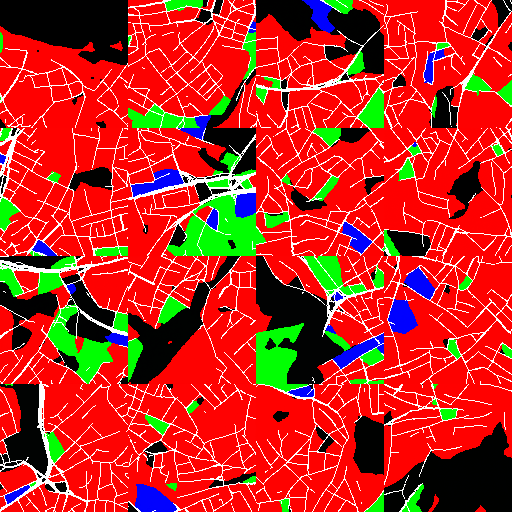

In [32]:
sample_images = sorted(glob.glob(f"{config.output_dir}/samples/*.png"))
Image.open(sample_images[-1])

# Generate new samples

In [ ]:
pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)
images = pipeline(batch_size = config.eval_batch_size,
                  generator=torch.manual_seed(config.seed),).images